In [1]:
import pandas as pd                  # 🐼 read & manage datasets
from scipy import stats              # numbers
import os                            # interact with os level operations and variables
import numpy as np                   # vectorized mathematics
from sklearn import preprocessing    # data cleaning stuffs
from scipy import stats              # stats functions
from pickle import dump, load        # 🥒 remember objects
from pathlib import Path             # for making directories if they don't exist
from statsmodels.formula.api import ols

import plotly.graph_objects as go    # ???
import plotly.figure_factory as ff   # ???
import plotly.express as px          # ???

import heapq                         # heaps find smallest K fast
from collections import Counter      # Count things using hashtables
from collections import defaultdict  # Dictionary, but better
import re                            # regular expressions are cool

In [2]:
ukbb_MetS_cols = ["eid",
                  "22001-0.0", # genetic sex
                  "4079-0.0",  # bp denominator
                  "4080-0.0",  # bp numerator
                  "30740-0.0", # glucose 
                  "30870-0.0", # triglycerides
                  "48-0.0",    # waist circumference
                  "30760-0.0"] # HDL cholesterol

In [3]:
test = pd.read_csv("/mnt/speliotes-lab/Projects/UK_ATLAS/Original/Pheno_2022_Oct/ukb669830.csv",usecols=ukbb_MetS_cols)
print(test.shape)

(502396, 8)


In [5]:
df = test.dropna(how="any")
print(df.shape)

(396781, 8)


In [31]:
MetS = {}
MetS["eid"] = df.eid
MetS["bp"] = df["4080-0.0"]/df["4079-0.0"] >= 130/85
MetS["gl"] = df["30740-0.0"] >= 6.1
MetS["tg"] = df["30870-0.0"] >= 1.7
MetS["wst"] = [w > 102 if s else w > 88 for s,w in zip(df["22001-0.0"],df["48-0.0"])]
MetS["HDL"] = [w < 1.0 if s else w < 1.3 for s,w in zip(df["22001-0.0"],df["30760-0.0"])]
MetS_df = pd.DataFrame(MetS)
MetS_df

,eid,bp,gl,tg,wst,HDL
0,1000013,True,False,False,False,False
1,1000024,True,False,False,False,False
2,1000036,True,False,True,True,False
3,1000048,True,False,True,True,False
4,1000055,True,False,False,False,False
...,...,...,...,...,...,...
502388,6026148,True,False,False,True,False
502389,6026155,True,False,False,False,False
502390,6026167,False,False,True,True,False
502391,6026172,False,True,False,False,False


In [57]:
MetS_feats = ["bp","gl","tg","wst","HDL"]
from itertools import combinations
bc_df = {"combo":[],
         "count":[],
         "unique_count":[]}
# iterate through all 3-way combinations of MetS
for combo in combinations(MetS_feats, 3):
    bc_df["combo"].append("{},{},{}".format(*combo))
    c1,c2,c3 = combo
    bc_df["count"].append(sum([e1 and e2 and e3 for e1,e2,e3 in zip(MetS_df[c1],MetS_df[c2],MetS_df[c3])]))
    c4,c5 = set(MetS_feats) - set(combo)
    bc_df["unique_count"].append(sum([(e1 and e2 and e3) and (not e4 and not e5) for e1,e2,e3,e4,e5 in zip(MetS_df[c1],MetS_df[c2],MetS_df[c3],MetS_df[c4],MetS_df[c5])]))
bc_df = pd.DataFrame(bc_df)
bc_df["fraction_unique"] = ["{:.1f}".format(e*100) for e in bc_df["unique_count"]/bc_df["count"]]
bc_df["count"] = ["{:,}".format(e) for e in bc_df["count"]]
bc_df

,combo,count,unique_count,fraction_unique
0,"bp,gl,tg","15,508",4249,27.4
1,"bp,gl,wst","13,629",2991,21.9
2,"bp,gl,HDL","9,053",880,9.7
3,"bp,tg,wst","56,193",28314,50.4
4,"bp,tg,HDL","42,144",16730,39.7
5,"bp,wst,HDL","32,575",7782,23.9
6,"gl,tg,wst","10,894",677,6.2
7,"gl,tg,HDL","7,956",204,2.6
8,"gl,wst,HDL","7,373",242,3.3
9,"tg,wst,HDL","29,452",5080,17.2


In [58]:
bc_df_t = bc_df.transpose()
latex_table = bc_df_t.to_latex()
print(latex_table)

\begin{tabular}{lllllllllll}
\toprule
{} &         0 &          1 &          2 &          3 &          4 &           5 &          6 &          7 &           8 &           9 \\
\midrule
combo           &  bp,gl,tg &  bp,gl,wst &  bp,gl,HDL &  bp,tg,wst &  bp,tg,HDL &  bp,wst,HDL &  gl,tg,wst &  gl,tg,HDL &  gl,wst,HDL &  tg,wst,HDL \\
count           &    15,508 &     13,629 &      9,053 &     56,193 &     42,144 &      32,575 &     10,894 &      7,956 &       7,373 &      29,452 \\
unique\_count    &      4249 &       2991 &        880 &      28314 &      16730 &        7782 &        677 &        204 &         242 &        5080 \\
fraction\_unique &      27.4 &       21.9 &        9.7 &       50.4 &       39.7 &        23.9 &        6.2 &        2.6 &         3.3 &        17.2 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1682292/2148964031.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = bc_df_t.to_latex()


In [34]:
t = (1,2,3)
print("{2},{0},{1}".format(*t))

3,1,2


In [63]:
lind_data = pd.read_table("Lind_GWAS.tsv")[['RISK ALLELE FREQUENCY',"OR or BETA"]]

In [66]:
fig = px.scatter(lind_data,x='RISK ALLELE FREQUENCY',y="OR or BETA",trendline="ols", trendline_options=dict(log_x=True),
                 title="Scatterplot of Risk Allele Frequency and Effect Size from Lind 2019 MetS GWAS results")

In [67]:
fig.write_image("fig1.png")

In [11]:
len([s for s in row_sums if s >= 3])

99044

In [13]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [28]:
bp_set = set(["{}".format(e) for e in MetS_df.eid[MetS_df.bp]])
glucose_set = set(["{}".format(e) for e in MetS_df.eid[MetS_df.glucose]])
tg_set = set(["{}".format(e) for e in MetS_df.eid[MetS_df.trigly]])
waist_set = set(["{}".format(e) for e in MetS_df.eid[MetS_df.waist]])
hdl_set = set(["{}".format(e) for e in MetS_df.eid[MetS_df.HDL]])

In [24]:
labels

{'001': '001: 0',
 '010': '010: 5',
 '011': '011: 0',
 '100': '100: 3',
 '101': '101: 2',
 '110': '110: 2',
 '111': '111: 3'}

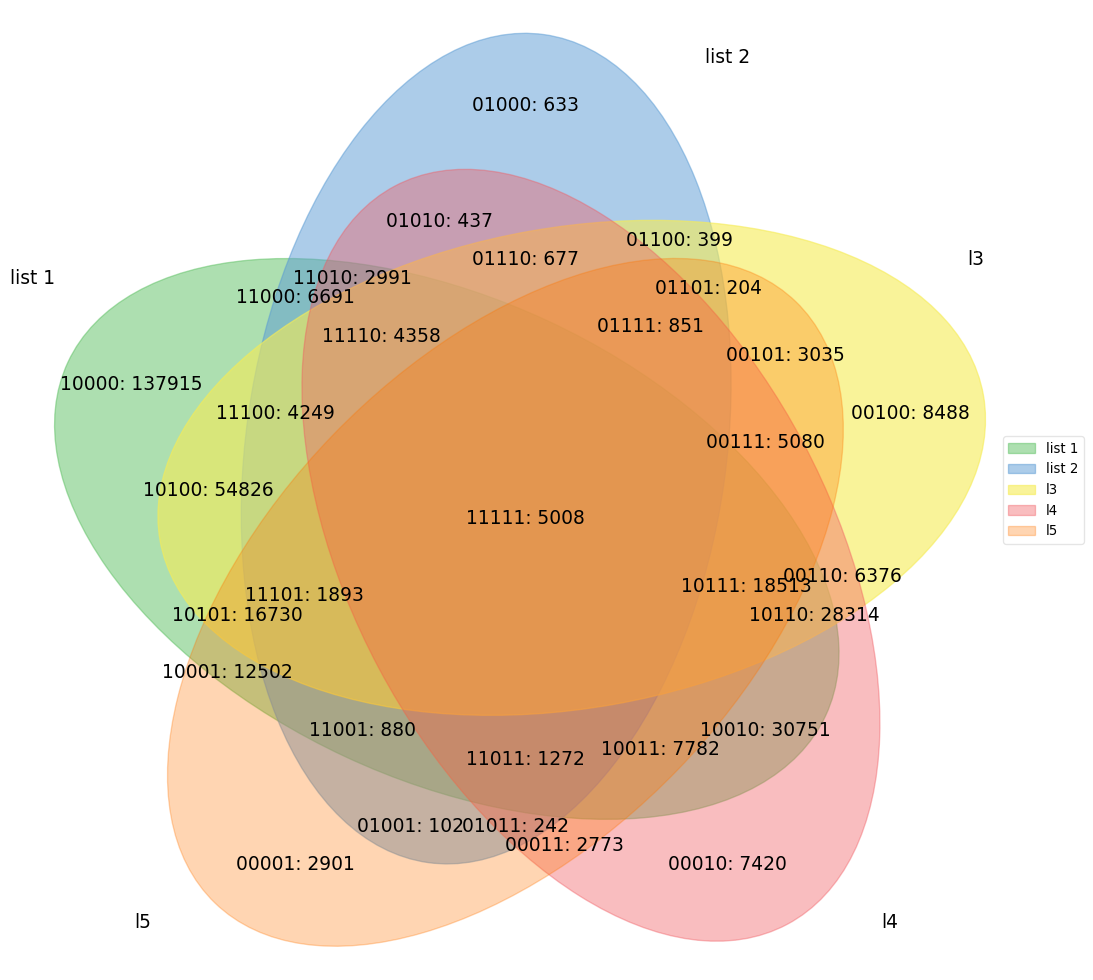

In [30]:
labels = get_labels([bp_set, glucose_set,tg_set,waist_set,hdl_set], fill=['number', 'logic'])
fig, ax = venn5(labels, names=['list 1', 'list 2',"l3","l4","l5"])
fig.show()

In [22]:
# coding: utf-8
from itertools import chain
try:
    # since python 3.10
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import math

default_colors = [
    # r, g, b, a
    [92, 192, 98, 0.5],
    [90, 155, 212, 0.5],
    [246, 236, 86, 0.6],
    [241, 90, 96, 0.4],
    [255, 117, 0, 0.3],
    [82, 82, 190, 0.2],
]
default_colors = [
    [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]]
    for i in default_colors
]

def draw_ellipse(fig, ax, x, y, w, h, a, fillcolor):
    e = patches.Ellipse(
        xy=(x, y),
        width=w,
        height=h,
        angle=a,
        color=fillcolor)
    ax.add_patch(e)

def draw_triangle(fig, ax, x1, y1, x2, y2, x3, y3, fillcolor):
    xy = [
        (x1, y1),
        (x2, y2),
        (x3, y3),
    ]
    polygon = patches.Polygon(
        xy=xy,
        closed=True,
        color=fillcolor)
    ax.add_patch(polygon)

def draw_text(fig, ax, x, y, text, color=[0, 0, 0, 1], fontsize=14, ha="center", va="center"):
    ax.text(
        x, y, text,
        horizontalalignment=ha,
        verticalalignment=va,
        fontsize=fontsize,
        color="black")

def draw_annotate(fig, ax, x, y, textx, texty, text, color=[0, 0, 0, 1], arrowcolor=[0, 0, 0, 0.3]):
    plt.annotate(
        text,
        xy=(x, y),
        xytext=(textx, texty),
        arrowprops=dict(color=arrowcolor, shrink=0, width=0.5, headwidth=8),
        fontsize=14,
        color=color,
        xycoords="data",
        textcoords="data",
        horizontalalignment='center',
        verticalalignment='center'
    )

def get_labels(data, fill=["number"]):
    """
    get a dict of labels for groups in data

    @type data: list[Iterable]
    @rtype: dict[str, str]

    input
      data: data to get label for
      fill: ["number"|"logic"|"percent"]

    return
      labels: a dict of labels for different sets

    example:
    In [12]: get_labels([range(10), range(5,15), range(3,8)], fill=["number"])
    Out[12]:
    {'001': '0',
     '010': '5',
     '011': '0',
     '100': '3',
     '101': '2',
     '110': '2',
     '111': '3'}
    """

    N = len(data)

    sets_data = [set(data[i]) for i in range(N)]  # sets for separate groups
    s_all = set(chain(*data))                     # union of all sets

    # bin(3) --> '0b11', so bin(3).split('0b')[-1] will remove "0b"
    set_collections = {}
    for n in range(1, 2**N):
        key = bin(n).split('0b')[-1].zfill(N)
        value = s_all
        sets_for_intersection = [sets_data[i] for i in range(N) if  key[i] == '1']
        sets_for_difference = [sets_data[i] for i in range(N) if  key[i] == '0']
        for s in sets_for_intersection:
            value = value & s
        for s in sets_for_difference:
            value = value - s
        set_collections[key] = value

    labels = {k: "" for k in set_collections}
    if "logic" in fill:
        for k in set_collections:
            labels[k] = k + ": "
    if "number" in fill:
        for k in set_collections:
            labels[k] += str(len(set_collections[k]))
    if "percent" in fill:
        data_size = len(s_all)
        for k in set_collections:
            labels[k] += "(%.1f%%)" % (100.0 * len(set_collections[k]) / data_size)

    return labels

def venn2(labels, names=['A', 'B'], **options):
    """
    plots a 2-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('01', '10', '11'),
              hence a valid set could look like: {'01': 'text 1', '10': 'text 2', '11': 'text 3'}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(2)])
    figsize = options.get('figsize', (9, 7))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=0.7)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.375, 0.3, 0.5, 0.5, 0.0, colors[0])
    draw_ellipse(fig, ax, 0.625, 0.3, 0.5, 0.5, 0.0, colors[1])
    draw_text(fig, ax, 0.74, 0.30, labels.get('01', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.26, 0.30, labels.get('10', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.30, labels.get('11', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.20, 0.56, names[0], colors[0], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.80, 0.56, names[1], colors[1], fontsize=fontsize, ha="left", va="bottom")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn3(labels, names=['A', 'B', 'C'], **options):
    """
    plots a 3-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('001', '010', '100', ...),
              hence a valid set could look like: {'001': 'text 1', '010': 'text 2', '100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(3)])
    figsize = options.get('figsize', (9, 9))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.333, 0.633, 0.5, 0.5, 0.0, colors[0])
    draw_ellipse(fig, ax, 0.666, 0.633, 0.5, 0.5, 0.0, colors[1])
    draw_ellipse(fig, ax, 0.500, 0.310, 0.5, 0.5, 0.0, colors[2])
    draw_text(fig, ax, 0.50, 0.27, labels.get('001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.73, 0.65, labels.get('010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.46, labels.get('011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.27, 0.65, labels.get('100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.46, labels.get('101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.65, labels.get('110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.51, labels.get('111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.15, 0.87, names[0], colors[0], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.85, 0.87, names[1], colors[1], fontsize=fontsize, ha="left", va="bottom")
    draw_text(fig, ax, 0.50, 0.02, names[2], colors[2], fontsize=fontsize, va="top")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn4(labels, names=['A', 'B', 'C', 'D'], **options):
    """
    plots a 4-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('0001', '0010', '0100', ...),
              hence a valid set could look like: {'0001': 'text 1', '0010': 'text 2', '0100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(4)])
    figsize = options.get('figsize', (12, 12))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.350, 0.400, 0.72, 0.45, 140.0, colors[0])
    draw_ellipse(fig, ax, 0.450, 0.500, 0.72, 0.45, 140.0, colors[1])
    draw_ellipse(fig, ax, 0.544, 0.500, 0.72, 0.45, 40.0, colors[2])
    draw_ellipse(fig, ax, 0.644, 0.400, 0.72, 0.45, 40.0, colors[3])
    draw_text(fig, ax, 0.85, 0.42, labels.get('0001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.68, 0.72, labels.get('0010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.77, 0.59, labels.get('0011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.32, 0.72, labels.get('0100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.71, 0.30, labels.get('0101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.66, labels.get('0110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.50, labels.get('0111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.14, 0.42, labels.get('1000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.17, labels.get('1001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.29, 0.30, labels.get('1010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.24, labels.get('1011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.23, 0.59, labels.get('1100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.24, labels.get('1101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.35, 0.50, labels.get('1110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.38, labels.get('1111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.13, 0.18, names[0], colors[0], fontsize=fontsize, ha="right")
    draw_text(fig, ax, 0.18, 0.83, names[1], colors[1], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.82, 0.83, names[2], colors[2], fontsize=fontsize, ha="left", va="bottom")
    draw_text(fig, ax, 0.87, 0.18, names[3], colors[3], fontsize=fontsize, ha="left", va="top")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn5(labels, names=['A', 'B', 'C', 'D', 'E'], **options):
    """
    plots a 5-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('00001', '00010', '00100', ...),
              hence a valid set could look like: {'00001': 'text 1', '00010': 'text 2', '00100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(5)])
    figsize = options.get('figsize', (13, 13))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.428, 0.449, 0.87, 0.50, 155.0, colors[0])
    draw_ellipse(fig, ax, 0.469, 0.543, 0.87, 0.50, 82.0, colors[1])
    draw_ellipse(fig, ax, 0.558, 0.523, 0.87, 0.50, 10.0, colors[2])
    draw_ellipse(fig, ax, 0.578, 0.432, 0.87, 0.50, 118.0, colors[3])
    draw_ellipse(fig, ax, 0.489, 0.383, 0.87, 0.50, 46.0, colors[4])
    draw_text(fig, ax, 0.27, 0.11, labels.get('00001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.72, 0.11, labels.get('00010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.55, 0.13, labels.get('00011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.91, 0.58, labels.get('00100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.78, 0.64, labels.get('00101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.84, 0.41, labels.get('00110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.76, 0.55, labels.get('00111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.90, labels.get('01000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.15, labels.get('01001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.42, 0.78, labels.get('01010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.15, labels.get('01011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.67, 0.76, labels.get('01100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.70, 0.71, labels.get('01101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.74, labels.get('01110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.64, 0.67, labels.get('01111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.10, 0.61, labels.get('10000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.20, 0.31, labels.get('10001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.76, 0.25, labels.get('10010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.23, labels.get('10011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.18, 0.50, labels.get('10100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.21, 0.37, labels.get('10101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.81, 0.37, labels.get('10110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.74, 0.40, labels.get('10111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.27, 0.70, labels.get('11000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.34, 0.25, labels.get('11001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.33, 0.72, labels.get('11010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.22, labels.get('11011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.25, 0.58, labels.get('11100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.28, 0.39, labels.get('11101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.36, 0.66, labels.get('11110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.47, labels.get('11111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.02, 0.72, names[0], colors[0], fontsize=fontsize, ha="right")
    draw_text(fig, ax, 0.72, 0.94, names[1], colors[1], fontsize=fontsize, va="bottom")
    draw_text(fig, ax, 0.97, 0.74, names[2], colors[2], fontsize=fontsize, ha="left")
    draw_text(fig, ax, 0.88, 0.05, names[3], colors[3], fontsize=fontsize, ha="left")
    draw_text(fig, ax, 0.12, 0.05, names[4], colors[4], fontsize=fontsize, ha="right")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn6(labels, names=['A', 'B', 'C', 'D', 'E'], **options):
    """
    plots a 6-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('000001', '000010', '000100', ...),
              hence a valid set could look like: {'000001': 'text 1', '000010': 'text 2', '000100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(6)])
    figsize = options.get('figsize', (20, 20))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.230, top=0.845)
    ax.set_xlim(left=0.173, right=0.788)

    # body
    # See https://web.archive.org/web/20040819232503/http://www.hpl.hp.com/techreports/2000/HPL-2000-73.pdf
    draw_triangle(fig, ax, 0.637, 0.921, 0.649, 0.274, 0.188, 0.667, colors[0])
    draw_triangle(fig, ax, 0.981, 0.769, 0.335, 0.191, 0.393, 0.671, colors[1])
    draw_triangle(fig, ax, 0.941, 0.397, 0.292, 0.475, 0.456, 0.747, colors[2])
    draw_triangle(fig, ax, 0.662, 0.119, 0.316, 0.548, 0.662, 0.700, colors[3])
    draw_triangle(fig, ax, 0.309, 0.081, 0.374, 0.718, 0.681, 0.488, colors[4])
    draw_triangle(fig, ax, 0.016, 0.626, 0.726, 0.687, 0.522, 0.327, colors[5])
    draw_text(fig, ax, 0.212, 0.562, labels.get('000001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.430, 0.249, labels.get('000010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.356, 0.444, labels.get('000011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.609, 0.255, labels.get('000100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.323, 0.546, labels.get('000101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.513, 0.316, labels.get('000110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.523, 0.348, labels.get('000111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.747, 0.458, labels.get('001000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.325, 0.492, labels.get('001001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.670, 0.481, labels.get('001010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.359, 0.478, labels.get('001011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.444, labels.get('001100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.344, 0.526, labels.get('001101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.466, labels.get('001110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.363, 0.503, labels.get('001111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.750, 0.616, labels.get('010000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.682, 0.654, labels.get('010001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.402, 0.310, labels.get('010010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.392, 0.421, labels.get('010011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.691, labels.get('010100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.651, 0.644, labels.get('010101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.490, 0.340, labels.get('010110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.468, 0.399, labels.get('010111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.692, 0.545, labels.get('011000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.666, 0.592, labels.get('011001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.665, 0.496, labels.get('011010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.374, 0.470, labels.get('011011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.537, labels.get('011100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.652, 0.579, labels.get('011101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.488, labels.get('011110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.389, 0.486, labels.get('011111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.553, 0.806, labels.get('100000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.313, 0.604, labels.get('100001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.388, 0.694, labels.get('100010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.375, 0.633, labels.get('100011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.605, 0.359, labels.get('100100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.334, 0.555, labels.get('100101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.582, 0.397, labels.get('100110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.542, 0.372, labels.get('100111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.468, 0.708, labels.get('101000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.355, 0.572, labels.get('101001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.420, 0.679, labels.get('101010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.375, 0.597, labels.get('101011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.641, 0.436, labels.get('101100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.348, 0.538, labels.get('101101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.635, 0.453, labels.get('101110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.370, 0.548, labels.get('101111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.594, 0.689, labels.get('110000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.579, 0.670, labels.get('110001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.398, 0.670, labels.get('110010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.395, 0.653, labels.get('110011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.633, 0.682, labels.get('110100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.616, 0.656, labels.get('110101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.587, 0.427, labels.get('110110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.526, 0.415, labels.get('110111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.495, 0.677, labels.get('111000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.505, 0.648, labels.get('111001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.428, 0.663, labels.get('111010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.430, 0.631, labels.get('111011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.639, 0.524, labels.get('111100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.591, 0.604, labels.get('111101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.622, 0.477, labels.get('111110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.501, 0.523, labels.get('111111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.674, 0.824, names[0], colors[0], fontsize=fontsize)
    draw_text(fig, ax, 0.747, 0.751, names[1], colors[1], fontsize=fontsize)
    draw_text(fig, ax, 0.739, 0.396, names[2], colors[2], fontsize=fontsize)
    draw_text(fig, ax, 0.700, 0.247, names[3], colors[3], fontsize=fontsize)
    draw_text(fig, ax, 0.291, 0.255, names[4], colors[4], fontsize=fontsize)
    draw_text(fig, ax, 0.203, 0.484, names[5], colors[5], fontsize=fontsize)
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

